In [ ]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d msarmi9/food101tiny --force


In [ ]:
!unzip -o food101tiny.zip

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
data_dir = 'data/food-101-tiny/'
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')
train_datagen_1 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen_1 = ImageDataGenerator(rescale=1./255)
def load_images_from_directory(directory, target_size=(224, 224)):
    images = []
    labels = []
    label_names = os.listdir(directory)

    for label in label_names:
        class_dir = os.path.join(directory, label)
        if not os.path.isdir(class_dir):
            continue
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = load_img(img_path, target_size=target_size)
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label_names.index(label))

    images = np.array(images)
    labels = np.array(labels)
    return images, labels


train_images, train_labels = load_images_from_directory(train_dir)
valid_images, valid_labels = load_images_from_directory(valid_dir)
num_classes = len(os.listdir(train_dir))
train_labels = to_categorical(train_labels, num_classes=num_classes)
valid_labels = to_categorical(valid_labels, num_classes=num_classes)

X_train, X_test, y_train, y_test = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42
)
train_generator_1 = train_datagen_1.flow(
    X_train, y_train, batch_size=32
)

test_generator_1 = valid_datagen_1.flow(
    X_test, y_test, batch_size=32
)

validation_generator_1 = valid_datagen_1.flow(
    valid_images, valid_labels, batch_size=32
)


In [ ]:
from tensorflow.keras import layers, models, Input
from tensorflow.keras.applications import MobileNetV2
# Define the input tensor explicitly
input_tensor = Input(shape=(224, 224, 3))

# Load the base model with MobileNetV2
base_model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Add custom classification layers on top of the base model
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
output_tensor = layers.Dense(10, activation='softmax')(x)

# Create the full model
model = models.Model(inputs=input_tensor, outputs=output_tensor)

# Compile the model with categorical_crossentropy loss function
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Check the model summary
model.summary()




<ipython-input-27-63d257ca52ab>:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,439,754 (9.31 MB)

 Trainable params: 181,770 (710.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
history=model.fit(
    train_generator_1,
    epochs=4,
    validation_data=validation_generator_1
    )

Epoch 1/4
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 481ms/step - accuracy: 0.3065 - loss: 1.9455 - val_accuracy: 0.7040 - val_loss: 0.9999
Epoch 2/4
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 318ms/step - accuracy: 0.6963 - loss: 0.8958 - val_accuracy: 0.7360 - val_loss: 0.8538
Epoch 3/4
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 333ms/step - accuracy: 0.7623 - loss: 0.7044 - val_accuracy: 0.7460 - val_loss: 0.7370
Epoch 4/4
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 332ms/step - accuracy: 0.8109 - loss: 0.5507 - val_accuracy: 0.7620 - val_loss: 0.7076


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))  # Resize to the input size required by MobileNetV2
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = preprocess_input(image)  # Preprocess for MobileNetV2
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

image_path = '/content/data/food-101-tiny/train/french_toast/100223.jpg'
processed_image = preprocess_image(image_path)


In [ ]:
# Predict the class
predicted_class = model.predict(processed_image)
predicted_class_index = np.argmax(predicted_class, axis=1)[0]

# Assuming you have a mapping of class indices to food names
food_classes = ['apple_pie', 'bibimap', 'cannoli', 'edamame' , 'falafel', 'french_toast', 'ice_cream', 'ramen', 'sushi', 'tiramisu']  # Replace with actual class names
predicted_food = food_classes[predicted_class_index]

print(f"Predicted food: {predicted_food}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted food: falafel


In [ ]:
import cv2
from google.colab.patches import cv2_imshow

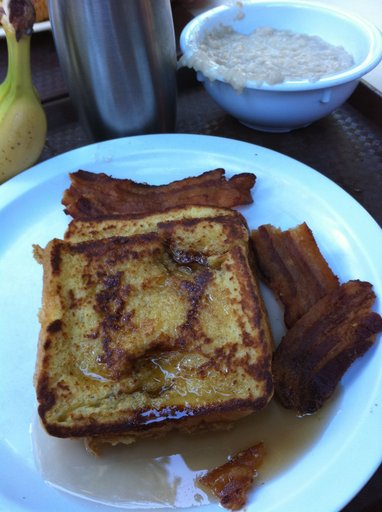

In [ ]:
image=cv2.imread(image_path)
cv2_imshow(image)

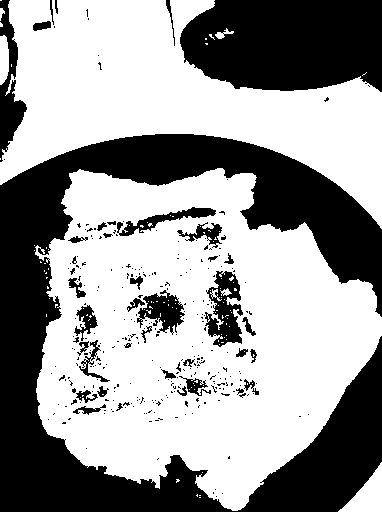

In [ ]:
import cv2
from google.colab.patches import cv2_imshow  # Import the Colab-compatible imshow

def segment_image(image_path):
    image = cv2.imread(image_path, 0)
    _, segmented_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)
    return segmented_image

segmented_image = segment_image(image_path)
cv2_imshow(segmented_image)  # Use cv2_imshow instead of cv2.imshow
# cv2.waitKey(0)  # Not needed in Colab
# cv2.destroyAllWindows() # Not needed in Colab

In [ ]:
def calculate_area(segmented_image):
    # Count the number of white pixels in the binary image
    area = np.sum(segmented_image == 255)
    return area

area = calculate_area(segmented_image)
print(f"Estimated Area: {area} pixels")


Estimated Area: 118025 pixels


In [ ]:
def estimate_depth_map(image):
    # Returns a depth map with random values for illustration
    return np.random.rand(*image.shape[:2]) * 10


In [ ]:

def estimate_volume(depth_map, segmentation_mask):
    # Estimate volume from depth map and segmentation mask
    table_height = np.min(depth_map)  # Simplified assumption of the table surface height
    volume = np.sum((depth_map - table_height) * (segmentation_mask > 0))  # Calculate volume
    volume_ml = volume/1000   # Convert volume to milliliters
    return volume_ml



In [ ]:
volume = estimate_volume(estimate_depth_map(image), segmented_image) # Pass the segmented image as the mask
print(f"Estimated Volume: {volume} cubic pixels")

Estimated Volume: 590.6607979612412 cubic pixels


In [ ]:
# Example density (g/cubic pixel) for some food types
food_density = {
    'apple_pie': 0.0011,  # grams per cubic pixel
    'bibimbap': 0.0012,  # grams per cubic pixel
    'cannoli': 0.0015,  # grams per cubic pixel
    'edamame': 0.0010,  # grams per cubic pixel
    'falafel': 0.0014,  # grams per cubic pixel
    'french_toast': 0.0013,  # grams per cubic pixel
    'ice_cream': 0.0016,  # grams per cubic pixel
    'ramen': 0.0012,  # grams per cubic pixel
    'tiramisu': 0.0015   # grams per cubic pixel
}


density = food_density.get(predicted_food, 0.001)  # Default to a generic density if unknown
weight = volume * density

print(f"Estimated Weight: {weight} grams")


Estimated Weight: 0.7357198362152948 grams


In [ ]:
# Example calories per gram for each food type
calorie_content= {
    'apple_pie': 1.6,
    'bibimbap': 1.3,
    'cannoli': 3.0,
    'edamame': 1.0,
    'falafel': 2.5,
    'french_toast': 2.0,
    'ice_cream': 3.5,
    'ramen': 1.8,
    'tiramisu': 3.0
}

calories = weight * calorie_content .get(predicted_food, 0.5)  # Default to 0.5 kcal/g if unknown

print(f"Estimated Calories: {calories} kcal")


Estimated Calories: 1.839299590538237 kcal


In [ ]:
def estimate_calories(image_path):
    # Step 1: Preprocess and predict the food type
    processed_image = preprocess_image(image_path)
    predicted_class = model.predict(processed_image)
    predicted_class_index = np.argmax(predicted_class, axis=1)[0]
    predicted_food = food_classes[predicted_class_index]

    # Step 2: Segment the image
    segmented_image = segment_image(image_path)

    # Step 3: Estimate the area and volume
    area = calculate_area(segmented_image)
    volume = estimate_volume(estimate_depth_map(image), segmented_image)

    # Step 4: Convert volume to weight
    density = food_density.get(predicted_food, 0.001)
    weight = volume * density

    # Step 5: Estimate calories
    calories = weight * calorie_content.get(predicted_food, 0.5)

    return predicted_food, weight, calories

# Example usage:
predicted_food, weight, calories = estimate_calories(image_path)
print(f"Food: {predicted_food}, Weight: {weight} grams, Calories: {calories} kcal")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Food: falafel, Weight: 0.8245258195812959 grams, Calories: 2.0613145489532396 kcal
